In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import date

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Read files
def read_file(csv):
    file = pd.read_csv(csv)
    return file

In [3]:
cpm_raw = read_file('cpm_estimates.csv')

In [4]:
cpm_raw = cpm_raw.drop_duplicates()

In [5]:
cpm_missing = cpm_raw.isna()
print(cpm_missing.sum())

account_name    0
age_min         0
age_max         0
female          0
male            0
cpm             0
hID             0
date            0
dtype: int64


In [6]:
page_level = read_file('Raw Page Level Data.csv')

In [7]:
cpm_raw['date'] = pd.to_datetime(cpm_raw['date'], format='%Y-%m-%d').dt.floor('D')
page_level['date'] = pd.to_datetime(page_level['date'], format='%Y-%m-%d').dt.floor('D')

In [8]:
page_level['year'] = pd.DatetimeIndex(page_level['date']).year
page_level['month'] = pd.DatetimeIndex(page_level['date']).month
page_level['quarter'] = pd.DatetimeIndex(page_level['date']).quarter
page_level['day'] = pd.DatetimeIndex(page_level['date']).day
page_level['weekday'] = page_level['date'].apply(lambda a: a.weekday())

In [9]:
# ##CPM DATA
# change the type of age_min from int to str, so that I can combine age_min with age_max
cpm_raw['age_min'] = cpm_raw['age_min'].astype(str) 
print(cpm_raw.dtypes)
# combine the age_min and age_max and create a new column
cpm_raw['age'] = cpm_raw['age_min'] + '-' + cpm_raw['age_max'] 
print(cpm_raw.head())

account_name            object
age_min                 object
age_max                 object
female                   int64
male                     int64
cpm                    float64
hID                      int64
date            datetime64[ns]
dtype: object
  account_name age_min age_max  female  male       cpm                  hID  \
0      TV Land      18      24       0     1  3.678763 -1394022326274885364   
1      TV Land      18      24       1     0  3.026950 -1394022326274885364   
2      TV Land      18      24       1     1  3.114728 -1394022326274885364   
3      TV Land      25      34       0     1  3.011565 -1394022326274885364   
4      TV Land      25      34       1     0  4.032152 -1394022326274885364   

        date    age  
0 2018-10-02  18-24  
1 2018-10-02  18-24  
2 2018-10-02  18-24  
3 2018-10-02  25-34  
4 2018-10-02  25-34  


In [10]:
# ##PAGE LEVEL DATA
# Filtering data only for age and gender 
pg_level = page_level[page_level['name'] == 'page_impressions_by_age_gender_unique'].copy()

In [11]:
# Check the selected page level data
print(pg_level.shape)
pg_missing =pg_level.isna()
print(pg_missing.sum())


(2748559, 10)
Unnamed: 0    0
date          0
name          0
metric        0
value         0
hID           0
year          0
month         0
day           0
weekday       0
dtype: int64


In [12]:
# Split the 'metric' column and extract this column from original df
metric_split = pg_level["metric"].str.split(".", n = 1, expand = True)
# Check the extracted split metric column
print(metric_split.head())
# Add the split columns into the original page level data
pg_level['sex'] = metric_split[0]
pg_level['age'] = metric_split[1]
# Drop the original 'metric' column
pg_level.drop(columns = ['metric'],inplace=True)   

# change the age with 65+ into 18-65+,
pg_level = pg_level.replace('65+','65-100')
# Split the 'age' column and extract this column from original df
age_split = pg_level["age"].str.split("-", n = 1, expand = True)  
# Check the extracted split 'age' column
print(age_split.head())
# Add the split columns into the original page level data
pg_level['age_min'] = age_split[0]
pg_level['age_max'] = age_split[1] 
pg_level.age = pg_level.age.replace({'65-100':'65+'})
# Check the page level data
pg_level.info()


#Adding male female columns
pg_level['female'] = [1 if 'F' in sex else 1 if 'U' in sex else 0 for sex in pg_level['sex']]
pg_level['male'] = [1 if 'M' in sex else 1 if 'U' in sex else 0 for sex in pg_level['sex']]


    0      1
0   U  45-54
10  F    65+
14  U  55-64
18  M  55-64
43  M    65+
     0    1
0   45   54
10  65  100
14  55   64
18  55   64
43  65  100
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748559 entries, 0 to 33744728
Data columns (total 13 columns):
Unnamed: 0    int64
date          datetime64[ns]
name          object
value         float64
hID           int64
year          int64
month         int64
day           int64
weekday       int64
sex           object
age           object
age_min       object
age_max       object
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 293.6+ MB


In [13]:
# add a new 'sex' column into CPM dataset
is_female = cpm_raw.female == 1 
is_male = cpm_raw.male == 1 
not_female = cpm_raw.female == 0 
not_male = cpm_raw.male == 0 
cpm_raw.loc[is_female & not_male,'sex']='F'
cpm_raw.loc[not_female & is_male,'sex']='M'
cpm_raw.loc[is_female & is_male,'sex']='U' 
# deal with age_max column including '65+' value
cpm_raw.age_max = cpm_raw.age_max.replace({'65+': 100})
# transfer data type of age_max and age_min
cpm_raw['age_max'] = cpm_raw['age_max'].astype('int64')
cpm_raw['age_min'] = cpm_raw['age_min'].astype('int64')
# add year, month, day and weekday columns into CPM dataset
cpm_raw['year'] = pd.DatetimeIndex(cpm_raw['date']).year
cpm_raw['month'] = pd.DatetimeIndex(cpm_raw['date']).month
cpm_raw['day'] = pd.DatetimeIndex(cpm_raw['date']).day
cpm_raw['weekday'] = cpm_raw['date'].apply(lambda a: a.weekday())
# Check the CPM data
cpm_raw.head()
cpm_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116652 entries, 0 to 182296
Data columns (total 14 columns):
account_name    116652 non-null object
age_min         116652 non-null int64
age_max         116652 non-null int64
female          116652 non-null int64
male            116652 non-null int64
cpm             116652 non-null float64
hID             116652 non-null int64
date            116652 non-null datetime64[ns]
age             116652 non-null object
sex             116652 non-null object
year            116652 non-null int64
month           116652 non-null int64
day             116652 non-null int64
weekday         116652 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(9), object(3)
memory usage: 13.3+ MB


In [14]:
# Filter organic traffic values from page level data
pg_level_organic_traffic = page_level[page_level['name'] == 'page_impressions_organic'].copy()

In [15]:
# calculate the average organic traffic for each month
pg_level_organic_traffic_day = pg_level_organic_traffic.groupby(['hID','year','month','day'])['value'].mean().to_frame('Avg Organic Traffic')
pg_level_organic_traffic_day.head()

Avg Organic Traffic
hID                  year month day                     
-9219689609259275298 2018 1     1                   60.0
                                2                   16.0
                                3                    5.0
                                4                    5.0
                                5                   18.0

In [16]:
# join the average organic traffic values into CPM data
join = pd.merge(cpm_raw,pg_level_organic_traffic_day,on = ['hID','year','month','day'],how = 'left')
join.head() 

,account_name,age_min,age_max,female,male,cpm,hID,date,age,sex,year,month,day,weekday,Avg Organic Traffic
0,TV Land,18,24,0,1,3.678763,-1394022326274885364,2018-10-02,18-24,M,2018,10,2,1,577982.0
1,TV Land,18,24,1,0,3.026950,-1394022326274885364,2018-10-02,18-24,F,2018,10,2,1,577982.0
2,TV Land,18,24,1,1,3.114728,-1394022326274885364,2018-10-02,18-24,U,2018,10,2,1,577982.0
3,TV Land,25,34,0,1,3.011565,-1394022326274885364,2018-10-02,25-34,M,2018,10,2,1,577982.0
4,TV Land,25,34,1,0,4.032152,-1394022326274885364,2018-10-02,25-34,F,2018,10,2,1,577982.0


In [17]:
# join the average organic traffic into page level
pg_level = pd.merge(left = pg_level, right = pg_level_organic_traffic_day, on=['hID','year','month','day'], how = 'left')

In [18]:
# drop sex and age variables
df = join.drop(columns = ['sex'])
print(df.head())
# check if there is any missing values
df.isnull().any() #find there are missing values in value column

  account_name  age_min  age_max  female  male       cpm                  hID  \
0      TV Land       18       24       0     1  3.678763 -1394022326274885364   
1      TV Land       18       24       1     0  3.026950 -1394022326274885364   
2      TV Land       18       24       1     1  3.114728 -1394022326274885364   
3      TV Land       25       34       0     1  3.011565 -1394022326274885364   
4      TV Land       25       34       1     0  4.032152 -1394022326274885364   

        date    age  year  month  day  weekday  Avg Organic Traffic  
0 2018-10-02  18-24  2018     10    2        1             577982.0  
1 2018-10-02  18-24  2018     10    2        1             577982.0  
2 2018-10-02  18-24  2018     10    2        1             577982.0  
3 2018-10-02  25-34  2018     10    2        1             577982.0  
4 2018-10-02  25-34  2018     10    2        1             577982.0  


account_name           False
age_min                False
age_max                False
female                 False
male                   False
cpm                    False
hID                    False
date                   False
age                    False
year                   False
month                  False
day                    False
weekday                False
Avg Organic Traffic     True
dtype: bool

In [19]:
df_ml = df.copy() 
print(df_ml.isnull().sum(axis=0))

account_name               0
age_min                    0
age_max                    0
female                     0
male                       0
cpm                        0
hID                        0
date                       0
age                        0
year                       0
month                      0
day                        0
weekday                    0
Avg Organic Traffic    14518
dtype: int64


In [20]:
# Encoding the Independent Variable Account name
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
#df_ml.iloc[:, 0] = labelencoder_X.fit_transform(df_ml.iloc[:, 0])
df_ml.iloc[:, 8] = labelencoder_X.fit_transform(df_ml.iloc[:, 8])

In [21]:
def impute_zero_cpm(data):
    non_zero_cpm = data[data['cpm']!=0].copy()
    zero_cpm = data[data['cpm']==0].copy()
    xcol = ['age_min', 'age_max', 'female', 'male', 'hID', 'month', 'year', 'weekday']
    ycol = ['cpm']
    X_nona = non_zero_cpm[xcol]
    y_nona = non_zero_cpm[ycol]
    
    from sklearn.model_selection import train_test_split
    X_nona_train, X_nona_test, y_nona_train, y_nona_test = train_test_split(X_nona, y_nona, train_size = 0.8, test_size = 0.2, random_state = 222)
    
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(X_nona_train, np.ravel(y_nona_train,order='C'))
    
    regressor.score(X_nona_train,y_nona_train) #low r square value --> linear regression model is not good to predict organic traffic
    
    from sklearn.ensemble import RandomForestRegressor
    rf_regressor = RandomForestRegressor(random_state=0)
    rf_regressor.fit(X_nona_train,np.ravel(y_nona_train,order='C'))
    
    score = rf_regressor.score(X_nona_train,y_nona_train) # good r square value
    print('\nR Sq value for Random Forest while imputing CPM value {}\n'.format(score))
    
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    y_nona_predict = rf_regressor.predict(X_nona_test)
    rmse_rf = sqrt(mean_squared_error(y_nona_test,y_nona_predict))
    print('\nRMSE ofthe Random Forest Model {}\n'.format(rmse_rf)) #low rmse --> use random forest to predict unknown values
    
    # predict unknown values
    X_na = zero_cpm[xcol]
    y_na = rf_regressor.predict(X_na)
    zero_cpm['cpm'] = y_na
    
    # merge df_ml_nona and df_ml_na
    df_prep = non_zero_cpm.append(zero_cpm)
    return df_prep

In [22]:
df_imp_cpm = impute_zero_cpm(df_ml)

C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



R Sq value for Random Forest while imputing CPM value 0.943733655821672


RMSE ofthe Random Forest Model 0.3949370141241223



In [23]:
#Checking for 0 cpm
df_imp_cpm[df_imp_cpm['cpm']==0][['hID','age_min', 'age_max','month', 'year','cpm']]

df_imp_cpm.iloc[:, 0] = labelencoder_X.fit_transform(df_imp_cpm.iloc[:, 0])

In [24]:
def impute_miss_val(data):
    # split data including missing values and excluding missing values
    data['NA'] = data['Avg Organic Traffic'].isna().copy()
    df_ml_nona = data[data['NA']== False].copy()
    df_ml_na = data[data['NA']== True].copy()
    xcol = ['account_name', 'age_min', 'age_max', 'female', 'male', 'month', 'year', 'weekday','day']
    ycol = ['Avg Organic Traffic']
    X_nona = df_ml_nona[xcol]
    y_nona = df_ml_nona[ycol]
    
    from sklearn.model_selection import train_test_split
    X_nona_train, X_nona_test, y_nona_train, y_nona_test = train_test_split(X_nona, y_nona, train_size = 0.8, test_size = 0.2, random_state = 222)
    
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(X_nona_train,np.ravel(y_nona_train,order='C'))
    
    regressor.score(X_nona_train,y_nona_train) #low r square value --> linear regression model is not good to predict organic traffic
    
    from sklearn.ensemble import RandomForestRegressor
    rf_regressor = RandomForestRegressor(random_state=0)
    rf_regressor.fit(X_nona_train,np.ravel(y_nona_train,order='C'))
    
    score = rf_regressor.score(X_nona_train,y_nona_train) # good r square value
    print('R Sq value for Random Forest while imputing Average value {}'.format(score))
    
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    y_nona_predict = rf_regressor.predict(X_nona_test)
    rmse_rf = sqrt(mean_squared_error(y_nona_test,y_nona_predict))
    print('RMSE ofthe Random Forest Model {}'.format(rmse_rf)) #low rmse --> use random forest to predict unknown values
    
    # predict unknown values
    X_na = df_ml_na[xcol]
    y_na = rf_regressor.predict(X_na)
    df_ml_na['Avg Organic Traffic'] = y_na
    
    # merge df_ml_nona and df_ml_na
    df_prep = df_ml_nona.append(df_ml_na)
    return df_prep

In [25]:
df_preprocess = impute_miss_val(df_imp_cpm)

C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R Sq value for Random Forest while imputing Average value 0.9999999956673951
RMSE ofthe Random Forest Model 1336.7770297227587


In [26]:
df_preprocess.iloc[:, 0] = labelencoder_X.inverse_transform(df_preprocess.iloc[:, 0])

df_preprocess.iloc[:, 0].head()

0    TV Land
1    TV Land
2    TV Land
3    TV Land
4    TV Land
Name: account_name, dtype: object

In [27]:
print(df_preprocess.isna().sum()) #check no missing values

# drop NA column
df_preprocess = df_preprocess.drop(columns='NA')
df_preprocess.head()


account_name           0
age_min                0
age_max                0
female                 0
male                   0
cpm                    0
hID                    0
date                   0
age                    0
year                   0
month                  0
day                    0
weekday                0
Avg Organic Traffic    0
NA                     0
dtype: int64


,account_name,age_min,age_max,female,male,cpm,hID,date,age,year,month,day,weekday,Avg Organic Traffic
0,TV Land,18,24,0,1,3.678763,-1394022326274885364,2018-10-02,1,2018,10,2,1,577982.0
1,TV Land,18,24,1,0,3.026950,-1394022326274885364,2018-10-02,1,2018,10,2,1,577982.0
2,TV Land,18,24,1,1,3.114728,-1394022326274885364,2018-10-02,1,2018,10,2,1,577982.0
3,TV Land,25,34,0,1,3.011565,-1394022326274885364,2018-10-02,7,2018,10,2,1,577982.0
4,TV Land,25,34,1,0,4.032152,-1394022326274885364,2018-10-02,7,2018,10,2,1,577982.0


In [28]:
# build linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm 
from scipy import stats


In [29]:
def linear_reg_model(IV_train, DV_train):
    regressor = LinearRegression()
    lm = regressor.fit(IV_train,DV_train)
    return lm



def r_squared(model, IV_train, DV_train):
    val = model.score(IV_train, DV_train)
    return val


def random_forest_model(IV_train, DV_train):
    rf_cpm = RandomForestRegressor(random_state=0)
    rf = rf_cpm.fit(IV_train, DV_train)
    return rf


  
def fun_predict(model, IV_test):
    pred = model.predict(IV_test)
    return pred


def cal_rmse(prediction, actual):
    error = sqrt(mean_squared_error(prediction, actual))
    return error

In [30]:
#Data Modeling
x_cpm = ['age_min', 'age_max', 'female','male', 'weekday','day','month', 'year']
y_cpm = ['cpm']
X = df_preprocess[x_cpm]
y = df_preprocess[y_cpm]

## Out of sample hold out


In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 222) 

In [75]:
#Linear Regression
lm_model = linear_reg_model(X_train, y_train)
r_sq_lm = r_squared(lm_model,X_train, y_train )
print('\nR Squared value of Linear Regression is {}%'.format(round(r_sq_lm*100,2)))
pred_lm = fun_predict(lm_model, X_test)
rmse_lm = cal_rmse(pred_lm, y_test)
print('\nRMSE value of Linear Regression on test data is {}\n'.format(rmse_lm))


R Squared value of Linear Regression is 80.33%

RMSE value of Linear Regression on test data is 0.5366093152397053



In [76]:
#Random Forest
rf_model = random_forest_model(X_train, y_train)
r_sq_rf = r_squared(rf_model,X_train, y_train)
print('\nR Squared value of Random Forest Regression is {}%'.format(round(r_sq_rf*100,2)))
pred_rf = fun_predict(rf_model, X_test)
rmse_rf = cal_rmse(pred_rf, y_test)
print('\nRMSE value of Random Forest Regression on test data is {}'.format(rmse_rf))

C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression is 97.88%

RMSE value of Random Forest Regression on test data is 0.17973548221312527


In [77]:
x_cpm_v = ['age_min', 'age_max', 'female','male', 'weekday','month', 'day', 'year','Avg Organic Traffic']

X = df_preprocess[x_cpm_v]
y = df_preprocess[y_cpm]

In [78]:
#out of sample hold out
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 222) 


In [79]:
#Linear Regression
lm_model = linear_reg_model(X_train, y_train)
r_sq_lm = r_squared(lm_model,X_train, y_train )
print('\nR Squared value of Linear Regression is {}%'.format(round(r_sq_lm*100,2)))
pred_lm = fun_predict(lm_model, X_test)
rmse_lm = cal_rmse(pred_lm, y_test)
print('\nRMSE value of Linear Regression on test data is {}\n'.format(rmse_lm))

#Random Forest
rf_model = random_forest_model(X_train, y_train)
r_sq_rf = r_squared(rf_model,X_train, y_train)
print('\nR Squared value of Random Forest Regression is {}%'.format(round(r_sq_rf*100,2)))
pred_rf = fun_predict(rf_model, X_test)
rmse_rf = cal_rmse(pred_rf, y_test)
print('\nRMSE value of Random Forest Regression on test data is {}'.format(rmse_rf))



R Squared value of Linear Regression is 80.34%

RMSE value of Linear Regression on test data is 0.5364644995116945



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression is 99.86%

RMSE value of Random Forest Regression on test data is 0.10397562483574943


## Time Dependent Hold Out

In [80]:
df_2018 = df_preprocess[(df_preprocess['year']==2018)]
df_2019 = df_preprocess[(df_preprocess['year']==2019)]

#Without average
X = df_2018[x_cpm]
y = df_2018[y_cpm]

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 222) 


#Linear Regression
lm_model = linear_reg_model(X_train, y_train)
r_sq_lm = r_squared(lm_model,X_train, y_train )
print('\nR Squared value of Linear Regression is {}%'.format(round(r_sq_lm*100,2)))
pred_lm = fun_predict(lm_model, X_test)
rmse_lm = cal_rmse(pred_lm, y_test)
print('\nRMSE value of Linear Regression on test data is {}\n'.format(rmse_lm))

#Random Forest
rf_model = random_forest_model(X_train, y_train)
r_sq_rf = r_squared(rf_model,X_train, y_train)
print('\nR Squared value of Random Forest Regression is {}%'.format(round(r_sq_rf*100,2)))
pred_rf = fun_predict(rf_model, X_test)
rmse_rf = cal_rmse(pred_rf, y_test)
print('\nRMSE value of Random Forest Regression on test data is {}'.format(rmse_rf))



R Squared value of Linear Regression is 51.79%

RMSE value of Linear Regression on test data is 0.654063329141011



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression is 99.58%

RMSE value of Random Forest Regression on test data is 0.06285320810781468


## Time Dependent with Average Organic Data

In [82]:
#With average
X = df_2018[x_cpm_v]
y = df_2018[y_cpm]

# Least Square lines
#sns.pairplot(df_preprocess, x_vars=x_cpm, y_vars='cpm', size=7, aspect=0.7, kind='reg')


#out of sample hold out
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 222) 


#Linear Regression
lm_model = linear_reg_model(X_train, y_train)
r_sq_lm = r_squared(lm_model,X_train, y_train )
print('\nR Squared value of Linear Regression is {}%'.format(round(r_sq_lm*100,2)))
pred_lm = fun_predict(lm_model, X_test)
rmse_lm = cal_rmse(pred_lm, y_test)
print('\nRMSE value of Linear Regression on test data is {}\n'.format(rmse_lm))

#Random Forest
rf_model = random_forest_model(X_train, y_train)
r_sq_rf = r_squared(rf_model,X_train, y_train)
print('\nR Squared value of Random Forest Regression is {}%'.format(round(r_sq_rf*100,2)))
pred_rf = fun_predict(rf_model, X_test)
rmse_rf = cal_rmse(pred_rf, y_test)
print('\nRMSE value of Random Forest Regression on test data is {}'.format(rmse_rf))



R Squared value of Linear Regression is 51.82%

RMSE value of Linear Regression on test data is 0.6541259642764419



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression is 99.79%

RMSE value of Random Forest Regression on test data is 0.07962192016921266


In [83]:
#Training on 2018 data without average column
df_lm_18 = linear_reg_model(df_2018[x_cpm], df_2018[y_cpm])
r_sq_lm18 = r_squared(df_lm_18, df_2018[x_cpm], df_2018[y_cpm])
print('\nR Squared value of Linear Regression on 2018 data is {}%'.format(round(r_sq_lm18*100,2)))

#Training on 2019 data without average column
df_lm_19 = linear_reg_model(df_2019[x_cpm], df_2019[y_cpm])
r_sq_lm19 = r_squared(df_lm_19, df_2019[x_cpm], df_2019[y_cpm])
print('\nR Squared value of Linear Regression on 2019 data is {}%'.format(round(r_sq_lm19*100,2)))

pred_2019_lm = fun_predict(df_lm_18,df_2019[x_cpm])
rmse19_lm = cal_rmse(pred_2019_lm,df_2019[y_cpm])
print('\nRMSE value of Linear Regression on 2019 test data is {}\n'.format(rmse19_lm))

# random forest
df_rf_18 = random_forest_model(df_2018[x_cpm], df_2018[y_cpm])
r_sq_rf = r_squared(df_rf_18, df_2018[x_cpm], df_2018[y_cpm])
print('\nR Squared value of Random Forest Regression on 2018 data is {}%'.format(round(r_sq_rf*100,2)))

pred_2019_rf = df_rf_18.predict(df_2019[x_cpm])
rmse19_rf = sqrt(mean_squared_error(pred_2019_rf,df_2019[y_cpm]))
print('\nRMSE value of Random Forest Regression on 2019 test data is {}\n'.format(rmse19_rf))



R Squared value of Linear Regression on 2018 data is 51.71%

R Squared value of Linear Regression on 2019 data is 77.38%

RMSE value of Linear Regression on 2019 test data is 2.5656498743865375



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression on 2018 data is 99.59%

RMSE value of Random Forest Regression on 2019 test data is 1.9654641337266294



In [84]:

#Training on 2018 data with average column
df_lm_18 = linear_reg_model(df_2018[x_cpm_v], df_2018[y_cpm])
r_sq_lm18 = r_squared(df_lm_18, df_2018[x_cpm_v], df_2018[y_cpm])
print('\nR Squared value of Linear Regression on 2018 data is {}%'.format(round(r_sq_lm18*100,2)))

pred_2019_lm = fun_predict(df_lm_18,df_2019[x_cpm_v])
rmse19_lm = cal_rmse(pred_2019_lm,df_2019[y_cpm])
print('\nRMSE value of Linear Regression on 2019 test data is {}\n'.format(rmse19_lm))

# random forest
df_rf_18 = random_forest_model(df_2018[x_cpm_v], df_2018[y_cpm])
r_sq_rf = r_squared(df_rf_18, df_2018[x_cpm_v], df_2018[y_cpm])
print('\nR Squared value of Random Forest Regression on 2018 data is {}%'.format(round(r_sq_rf*100,2)))

pred_2019_rf = df_rf_18.predict(df_2019[x_cpm_v])
rmse19_rf = sqrt(mean_squared_error(pred_2019_rf,df_2019[y_cpm]))
print('\nRMSE value of Random Forest Regression on 2019 test data is {}\n'.format(rmse19_rf))df_feb19_before = df_preprocess[(df_preprocess['year']==2018) | ((df_preprocess['year']==2019) & (df_preprocess['month']<2))]
df_feb19_after = df_preprocess[(df_preprocess['year']==2019) & (df_preprocess['month']>1)]

df_lm_19 = linear_reg_model(df_feb19_after[x_cpm], df_feb19_after[y_cpm])
r_sq_lm19 = r_squared(df_lm_19, df_feb19_after[x_cpm], df_feb19_after[y_cpm])
print('\nR Squared value of Linear Regression on 2019 data is {}%'.format(round(r_sq_lm19*100,2)))



R Squared value of Linear Regression on 2018 data is 51.73%

RMSE value of Linear Regression on 2019 test data is 2.5550561879630482



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression on 2018 data is 99.8%

RMSE value of Random Forest Regression on 2019 test data is 1.9829707434562658



In [88]:
df_feb19_before = df_preprocess[(df_preprocess['year']==2018) | ((df_preprocess['year']==2019) & (df_preprocess['month']<2))]
df_feb19_after = df_preprocess[(df_preprocess['year']==2019) & (df_preprocess['month']>1)]

df_lm_19 = linear_reg_model(df_feb19_after[x_cpm], df_feb19_after[y_cpm])
r_sq_lm19 = r_squared(df_lm_19, df_feb19_after[x_cpm], df_feb19_after[y_cpm])
print('\nR Squared value of Linear Regression on 2019 data is {}%'.format(round(r_sq_lm19*100,2)))
#Including the average column
# linear regression 
regressor = LinearRegression()
df_lm_feb19_before = regressor.fit(df_feb19_before[x_cpm_v], df_feb19_before[y_cpm])
rsq = df_lm_feb19_before.score(df_feb19_before[x_cpm_v], df_feb19_before[y_cpm])
print('\nR Squared value of Linear Regression on 2018 +Jan19 data is {}%'.format(round(rsq*100,2)))


pred_feb19_after_lm = regressor.predict(df_feb19_after[x_cpm_v])
rmse_feb19_after_lm = sqrt(mean_squared_error(pred_feb19_after_lm,df_feb19_after[y_cpm]))
print('\nRMSE value of Linear Regression on Feb19 and beyond test data is {}\n'.format(rmse_feb19_after_lm))


# random forest
df_rf_feb19_before = RandomForestRegressor(random_state=0)
df_rf_feb19_before.fit(df_feb19_before[x_cpm_v], df_feb19_before[y_cpm])

rf_rsq = df_rf_feb19_before.score(df_feb19_before[x_cpm_v], df_feb19_before[y_cpm])
print('\nR Squared value of Random Forest Regression on 2018 +Jan19 data is {}%'.format(round(rf_rsq*100,2)))

pred_feb19_after_rf = regressor.predict(df_feb19_after[x_cpm_v])
rmse_feb19_after_rf = sqrt(mean_squared_error(pred_feb19_after_rf,df_feb19_after[y_cpm]))
print('\nRMSE value of Random Forest Regression on Feb19 and beyond test data is {}\n'.format(rmse_feb19_after_rf))



R Squared value of Linear Regression on 2019 data is 78.03%

R Squared value of Linear Regression on 2018 +Jan19 data is 60.73%

RMSE value of Linear Regression on Feb19 and beyond test data is 0.4965728812100928



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



R Squared value of Random Forest Regression on 2018 +Jan19 data is 99.86%

RMSE value of Random Forest Regression on Feb19 and beyond test data is 0.4965728812100928



In [89]:
#Excluding the average column
# linear regression 
regressor = LinearRegression()
df_lm_feb19_before = regressor.fit(df_feb19_before[x_cpm], df_feb19_before[y_cpm])
rsq = df_lm_feb19_before.score(df_feb19_before[x_cpm], df_feb19_before[y_cpm])
print('\nR Squared value of Linear Regression on 2018 +Jan19 data is {}%'.format(round(rsq*100,2)))


pred_feb19_after_lm = regressor.predict(df_feb19_after[x_cpm])
rmse_feb19_after_lm = sqrt(mean_squared_error(pred_feb19_after_lm,df_feb19_after[y_cpm]))
print('\nRMSE value of Linear Regression on Feb19 and beyond test data is {}\n'.format(rmse_feb19_after_lm))


# random forest
df_rf_feb19_before = RandomForestRegressor(random_state=0)
df_rf_feb19_before.fit(df_feb19_before[x_cpm], df_feb19_before[y_cpm])

rf_rsq = df_rf_feb19_before.score(df_feb19_before[x_cpm], df_feb19_before[y_cpm])
print('\nR Squared value of Random Forest Regression on 2018 +Jan19 data is {}%'.format(round(rf_rsq*100,2)))

pred_feb19_after_rf = regressor.predict(df_feb19_after[x_cpm])
rmse_feb19_after_rf = sqrt(mean_squared_error(pred_feb19_after_rf,df_feb19_after[y_cpm]))
print('\nRMSE value of Random Forest Regression on Feb19 and beyond test data is {}\n'.format(rmse_feb19_after_rf))



R Squared value of Linear Regression on 2018 +Jan19 data is 60.71%

RMSE value of Linear Regression on Feb19 and beyond test data is 0.4951494603589918



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()



R Squared value of Random Forest Regression on 2018 +Jan19 data is 99.68%

RMSE value of Random Forest Regression on Feb19 and beyond test data is 0.4951494603589918



In [90]:
#Train= 2018 + Jan19 + Feb19
df_mar19_before = df_preprocess[(df_preprocess['year']==2018) | ((df_preprocess['year']==2019) & (df_preprocess['month']<3))]
df_mar19_after = df_preprocess[(df_preprocess['year']==2019) & (df_preprocess['month']>2)]

#With Average Column
# linear regression 
df_lm_mar19_before = regressor.fit(df_mar19_before[x_cpm_v], df_mar19_before[y_cpm])
rsq = df_lm_mar19_before.score(df_mar19_before[x_cpm_v], df_mar19_before[y_cpm])
print('\nR Squared value of Linear Regression on 2018 + JanFeb19  data is {}%'.format(round(rsq*100,2)))


pred_mar19_after_lm = regressor.predict(df_mar19_after[x_cpm_v])
rms_mar19_after_lm = sqrt(mean_squared_error(pred_mar19_after_lm,df_mar19_after[y_cpm]))
print('\nRMSE value of Linear Regression on Mar19 and beyond test data is {}\n'.format(rms_mar19_after_lm))
 

# random forest
df_rf_mar19_before = RandomForestRegressor(random_state=0)
df_rf_mar19_before.fit(df_mar19_before[x_cpm_v], df_mar19_before[y_cpm])

rsq = df_rf_mar19_before.score(df_mar19_before[x_cpm_v], df_mar19_before[y_cpm])
print('\nR Squared value of Random Forest Regression on 2018 + JanFeb19  data is {}%'.format(round(rsq*100,2)))


pred_mar19_after_rf = df_rf_mar19_before.predict(df_mar19_after[x_cpm_v])
rmse_mar19_after_rf = sqrt(mean_squared_error(pred_mar19_after_rf,df_mar19_after[y_cpm]))
print('\nRMSE value of Random Forest Regression on Mar19 and beyond test data is {}\n'.format(rmse_mar19_after_rf))
 



R Squared value of Linear Regression on 2018 + JanFeb19  data is 72.2%

RMSE value of Linear Regression on Mar19 and beyond test data is 0.556349259819553



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



R Squared value of Random Forest Regression on 2018 + JanFeb19  data is 99.82%

RMSE value of Random Forest Regression on Mar19 and beyond test data is 2.3565938460809064



In [91]:
#exclude average column
# linear regression 
df_lm_mar19_before = regressor.fit(df_mar19_before[x_cpm], df_mar19_before[y_cpm])
rsq = df_lm_mar19_before.score(df_mar19_before[x_cpm], df_mar19_before[y_cpm])
print('\nR Squared value of Random Forest Regression on 2018 + JanFeb19  data is {}%'.format(round(rsq*100,2)))


pred_mar19_after_lm = regressor.predict(df_mar19_after[x_cpm])
rms_mar19_after_lm = sqrt(mean_squared_error(pred_mar19_after_lm,df_mar19_after[y_cpm]))
print('\nRMSE value of Random Forest Regression on Mar19 and beyond test data is {}\n'.format(rms_mar19_after_lm))
  

# random forest
df_rf_mar19_before = RandomForestRegressor(random_state=0)
df_rf_mar19_before.fit(df_mar19_before[x_cpm], df_mar19_before[y_cpm])

rsq = df_rf_mar19_before.score(df_mar19_before[x_cpm], df_mar19_before[y_cpm])
print('\nR Squared value of Random Forest Regression on 2018 + JanFeb19  data is {}%'.format(round(rsq*100,2)))


pred_mar19_after_rf = df_rf_feb19_before.predict(df_mar19_after[x_cpm])
rmse_mar19_after_rf = sqrt(mean_squared_error(pred_mar19_after_rf,df_mar19_after[y_cpm]))
print('\nRMSE value of Random Forest Regression on Mar19 and beyond test data is {}\n'.format(rmse_mar19_after_rf))



R Squared value of Random Forest Regression on 2018 + JanFeb19  data is 72.2%

RMSE value of Random Forest Regression on Mar19 and beyond test data is 0.557847625621632



C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression on 2018 + JanFeb19  data is 96.96%

RMSE value of Random Forest Regression on Mar19 and beyond test data is 2.19213382263589



## Selecting the most efficient Model

In [31]:
#In our case, Random Forest with Ave column
x_cpm_v = ['age_min', 'age_max', 'female','male', 'weekday','month', 'day', 'year','Avg Organic Traffic']
y_cpm = ['cpm']
X = df_preprocess[x_cpm_v]
y = df_preprocess[y_cpm]

#Random Forest
rf_model = random_forest_model(X, y)
r_sq_rf = r_squared(rf_model,X, y)
print('\nR Squared value of Random Forest Regression is {}%'.format(round(r_sq_rf*100,2)))

C:\Users\Shakya Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Shakya Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app



R Squared value of Random Forest Regression is 99.86%


In [32]:
#Prediction on Page Level Data
ind_v_pg_lvl =  pg_level[x_cpm_v]

pred_cpm = fun_predict(rf_model, ind_v_pg_lvl)

y_cpm = pd.DataFrame(pred_cpm)

df_out = ind_v_pg_lvl.copy()

df_out['Predicted CPM'] = y_cpm.copy()

pg_level['Predicted CPM'] = y_cpm.copy()

In [33]:
pg_level['Predicted CPM'].drop_duplicates()

0          4.845982
1          3.389611
2          4.872370
3          5.157377
5          3.837600
6          4.125295
7          3.776966
8          4.830949
9          4.839940
10         3.779088
11         5.328857
14         3.486132
16         4.923971
17         3.483417
18         4.990039
19         4.921795
20         5.177903
22         4.317318
23         5.166391
24         3.381282
25         5.173160
26         3.849853
27         4.318326
28         3.780589
29         4.658995
32         4.637531
33         5.182160
34         5.318952
38         3.839439
40         5.312392
             ...   
2740443    0.829902
2740455    0.782117
2740456    1.032936
2740681    0.444748
2740817    0.454153
2742219    0.782958
2743086    0.802319
2743522    1.239871
2743551    1.098388
2744144    0.881245
2744181    0.794042
2744182    0.793693
2744185    1.012817
2744199    0.928696
2744841    0.821548
2745020    1.012185
2745239    0.456077
2745300    0.787330
2746248    0.864128


In [34]:
xx = df_preprocess.groupby(['year','account_name'])['cpm'].sum().to_frame('Total CPM')
cnt = xx.reset_index()
g = xx['Total CPM'].groupby(level=0, group_keys=False)
top_names = g.nlargest(10).reset_index()


Text(0.5, 1.0, 'Most Charged Channels')

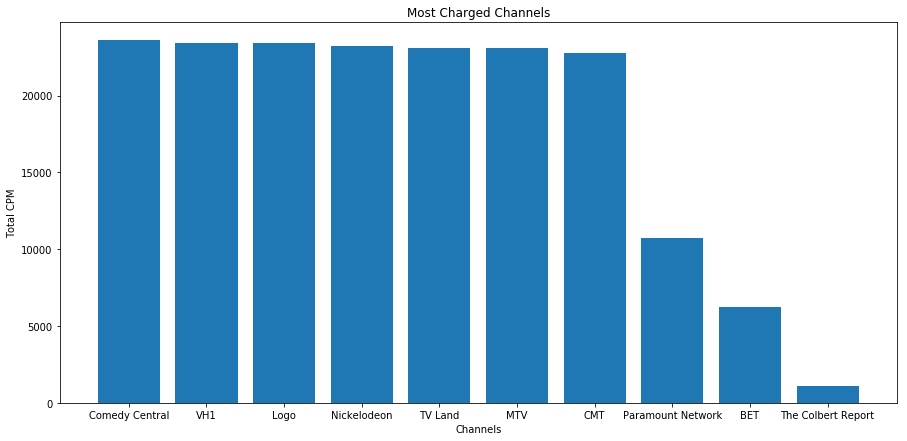

In [35]:
plt.figure(figsize=(15,7))
plt.bar(top_names['account_name'],top_names['Total CPM'])
plt.ylabel('Total CPM')
plt.xlabel('Channels')
plt.title('Most Charged Channels')

In [36]:
Accounts = pd.DataFrame(cpm_raw[['account_name','hID']]).drop_duplicates()

In [37]:
channels = pd.read_csv('Channels.csv',sep=',', engine='python')

In [38]:
channels.head()

,hID,account_name,Genre
0,-1.328840e+18,@midnight,Game show
1,-8.355430e+17,16 and Pregnant,Drama
2,-7.066630e+18,A Double Shot at Love,Game show
3,-8.377480e+18,A Thin Line,millennials
4,-1.651770e+18,Ain't That America With Lil Duval,Comedy


In [39]:
Accounts = pd.merge(left = Accounts, right = channels[['account_name','Genre']], on = 'account_name', how = 'left')

In [40]:
Accounts.to_csv('Accounts.csv')

In [41]:
cpm_raw[(cpm_raw['account_name']=='Comedy Central Stand-Up') | (cpm_raw['account_name']== 'Comedy Central Central') | (cpm_raw['account_name']=='Comedy Central')][['hID','account_name']].drop_duplicates()

,hID,account_name
49991,4702249124225659102,Comedy Central
147119,-1329614780165037998,Comedy Central Stand-Up
181043,-28254686295528164,Comedy Central Central


In [42]:
df_preprocess.loc[(df_preprocess['hID']==-1329614780165037998) | (df_preprocess['hID']==-28254686295528164),'hID'] = 4702249124225659102

In [50]:
cpm_raw.loc[(df_preprocess['hID']==-1329614780165037998) | (cpm_raw['hID']==-28254686295528164),'hID'] = 4702249124225659102

In [51]:
page_level.loc[(page_level['hID']==-1329614780165037998) | (page_level['hID']==-28254686295528164),'hID'] = 4702249124225659102

In [52]:
pg_level.loc[(pg_level['hID']==-1329614780165037998) | (pg_level['hID']==-28254686295528164),'hID'] = 4702249124225659102

In [43]:
organic_hID = page_level[page_level['name'] =='page_impressions_organic'].groupby(['hID'])['value'].sum().to_frame('Organic Impressions')
paid_hID = page_level[page_level['name'] =='page_impressions_paid'].groupby(['hID'])['value'].sum().to_frame('Paid Impressions')

OrgPaidImpression = pd.merge(left = organic_hID, right = paid_hID, on=['hID'], how = 'inner')

In [44]:
OrgPaidImpression.head()

,Organic Impressions,Paid Impressions
hID,,
-9219689609259275298,4816.0,0.0
-9147246796504653135,2421514.0,0.0
-9146494384264219298,359.0,0.0
-9130824000170732073,12103.0,0.0
-9130108445954082650,894883.0,0.0


In [45]:
page_level = pd.merge(left = page_level, right = Accounts[['hID','Genre']], on = 'hID', how = 'left')

In [135]:
df_age_gender = pd.merge(left = pg_level, right = Accounts[['hID','account_name','Genre']], on = 'hID', how = 'left')

In [136]:
df_age_gender.rename(columns = {'value':'impressions'}, inplace = True)
df_age_gender.head()

,Unnamed: 0,date,name,impressions,hID,year,month,day,weekday,sex,age,age_min,age_max,female,male,Avg Organic Traffic,Predicted CPM,account_name,Genre
0,0,2018-01-02,page_impressions_by_age_gender_unique,33.0,-4032924001207091538,2018,1,2,1,U,45-54,45,54,1,1,324908.0,4.845982,Basketball Wives,Reality TV Show
1,10,2018-01-04,page_impressions_by_age_gender_unique,2959.0,-4032924001207091538,2018,1,4,3,F,65+,65,100,1,0,308038.0,3.389611,Basketball Wives,Reality TV Show
2,14,2018-01-03,page_impressions_by_age_gender_unique,11.0,-4032924001207091538,2018,1,3,2,U,55-64,55,64,1,1,310441.0,4.872370,Basketball Wives,Reality TV Show
3,18,2018-01-01,page_impressions_by_age_gender_unique,443.0,-4032924001207091538,2018,1,1,0,M,55-64,55,64,0,1,359677.0,5.157377,Basketball Wives,Reality TV Show
4,43,2018-01-01,page_impressions_by_age_gender_unique,339.0,-4032924001207091538,2018,1,1,0,M,65+,65,100,0,1,359677.0,5.157377,Basketball Wives,Reality TV Show


In [167]:
df_demo = df_age_gender.groupby(['hID', 'age_min', 'age_max', 'male', 'female','year','month','sex'])[['impressions']].mean().round(0).reset_index()

In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [168]:
df_demo['age_range'] = df_demo[['age_min', 'age_max']].apply(lambda x: '-'.join(x), axis=1)

In [169]:
df_age_gender['age_range'] = df_age_gender[['age_min', 'age_max']].apply(lambda x: '-'.join(x), axis=1)

In [171]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129142 entries, 0 to 129141
Data columns (total 10 columns):
hID            129142 non-null int64
age_min        129142 non-null object
age_max        129142 non-null object
male           129142 non-null int64
female         129142 non-null int64
year           129142 non-null int64
month          129142 non-null int64
sex            129142 non-null object
impressions    129142 non-null float64
age_range      129142 non-null object
dtypes: float64(1), int64(5), object(4)
memory usage: 9.9+ MB


In [553]:
df_age_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748559 entries, 0 to 2748558
Data columns (total 25 columns):
Unnamed: 0               int64
date                     datetime64[ns]
name                     object
impressions              float64
hID                      int64
year                     int64
month                    int64
day                      int64
weekday                  int64
sex                      object
age                      object
age_min                  object
age_max                  object
female                   int64
male                     int64
Avg Organic Traffic      float64
Predicted CPM            float64
account_name             object
Genre                    object
age_range                object
demo_cluster             int32
impressions(in 1000s)    float64
revenue($)               float64
CPM_cost                 float64
Profit                   float64
dtypes: datetime64[ns](1), float64(7), int32(1), int64(8), object(8)
memory usage

In [172]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=3, random_state=0)

In [364]:
df_demo['demo_cluster'] = km.fit_predict(df_demo.iloc[:,[1,2,3,4]])

In [365]:
km.cluster_centers_

array([[ 45.        ,  54.        ,   0.649245  ,   0.64897916],
       [ 18.        ,  24.        ,   0.64601864,   0.64703063],
       [ 65.        , 100.        ,   0.64342826,   0.64485214],
       [ 35.        ,  44.        ,   0.65300361,   0.65263763],
       [ 55.        ,  64.        ,   0.64427439,   0.64531293],
       [ 25.        ,  34.        ,   0.65393609,   0.65409197],
       [ 13.        ,  17.        ,   0.62325637,   0.62878788]])

In [175]:
df_demo = pd.merge(df_demo, Accounts, on ='hID', how = 'left')

In [630]:
Account_imp = df_demo.groupby(['demo_cluster','age_range','sex','account_name','Genre'])[['impressions']].mean().round(0).reset_index()

In [631]:
Account_imp.to_csv('Impressions By Account.csv')

In [176]:
layer_demo = df_demo.groupby(['demo_cluster','age_range','sex'])[['impressions']].mean().round(0).reset_index()

In [177]:
layer_demo.pivot_table(columns = 'age_range', index = ['demo_cluster','sex']).fillna(0)

impressions                                              \
age_range              13-17    18-24    25-34    35-44    45-54   55-64   
demo_cluster sex                                                           
0            F        4934.0      0.0      0.0      0.0      0.0     0.0   
             M        3279.0      0.0      0.0      0.0      0.0     0.0   
             U          40.0      0.0      0.0      0.0      0.0     0.0   
1            F           0.0      0.0      0.0      0.0      0.0     0.0   
             M           0.0      0.0      0.0      0.0      0.0     0.0   
             U           0.0      0.0      0.0      0.0      0.0     0.0   
2            F           0.0      0.0      0.0  22110.0      0.0     0.0   
             M           0.0      0.0      0.0  18515.0      0.0     0.0   
             U           0.0      0.0      0.0    332.0      0.0     0.0   
3            F           0.0      0.0      0.0      0.0      0.0  5063.0   
             M           0.0      0.0      0.0      0.0      0.0  3373.0   
             U           0.0      0.0      0.0      0.0      0.0    84.0   
4            F           0.0      0.0  49434.0      0.0      0.0     0.0   
             M           0.0      0.0  45344.0      0.0      0.0     0.0   
             U           0.0      0.0    480.0      0.0      0.0     0.0   
5            F           0.0      0.0      0.0      0.0  10445.0     0.0   
             M           0.0      0.0      0.0      0.0   8128.0     0.0   
             U           0.0      0.0      0.0      0.0    160.0     0.0   
6            F           0.0  45728.0      0.0      0.0      0.0     0.0   
             M           0.0  37440.0      0.0      0.0      0.0     0.0   
             U           0.0    256.0      0.0      0.0      0.0     0.0   

                          
age_range         65-100  
demo_cluster sex          
0            F       0.0  
             M       0.0  
             U       0.0  
1            F    3360.0  
             M    2458.0  
             U      73.0  
2            F       0.0  
             M       0.0  
             U       0.0  
3            F       0.0  
             M       0.0  
             U       0.0  
4            F       0.0  
             M       0.0  
             U       0.0  
5            F       0.0  
             M       0.0  
             U       0.0  
6            F       0.0  
             M       0.0  
             U       0.0

In [178]:
df_age_gender['demo_cluster'] = km.predict(df_age_gender.loc[:,['age_min','age_max','male','female']])

In [179]:
df_age_gender.demo_cluster.unique()

array([5, 1, 3, 2, 6, 4, 0], dtype=int64)

In [180]:
df_demo.to_csv('df_demo.csv')

In [538]:
df_age_gender_filter = pd.merge(df_age_gender, Accounts['hID'], on ='hID', how ='inner')

In [141]:
df_age_gender.to_csv('demographic cluster pg level.csv')

In [235]:
df_age_gender_filter.to_csv('demographic cluster pg level filter.csv')

In [236]:
df_age_gender_filter[['year','demo_cluster','Predicted CPM']].pivot_table(columns = 'year', index = 'demo_cluster', aggfunc='mean').fillna(0)


Predicted CPM          
year                  2018      2019
demo_cluster                        
0                 3.644455  0.812430
1                 4.934833  1.667340
2                 4.175605  1.501585
3                 4.935283  1.665292
4                 3.883450  1.371707
5                 4.923977  1.664955
6                 3.623815  1.309782

In [240]:
df_age_gender_filter[['year','sex','demo_cluster','Predicted CPM']].pivot_table(columns = 'year', index = ['demo_cluster','sex'], aggfunc='mean').fillna(0)

Predicted CPM          
year                      2018      2019
demo_cluster sex                        
0            F        3.594140  0.759870
             M        3.828092  0.910709
             U        3.399920  0.736695
1            F        5.488127  1.807264
             M        4.697537  1.525723
             U        4.489659  1.668496
2            F        4.439244  1.597901
             M        4.153043  1.437350
             U        3.878525  1.463787
3            F        5.483784  1.806878
             M        4.697836  1.525300
             U        4.491324  1.662254
4            F        4.206141  1.430242
             M        3.728523  1.284022
             U        3.684422  1.405261
5            F        5.479358  1.806008
             M        4.699124  1.524253
             U        4.486670  1.664388
6            F        3.592813  1.329303
             M        3.829477  1.292548
             U        3.397332  1.306854

In [253]:
CPMbyAcct = df_age_gender_filter[['year','Predicted CPM','account_name']].pivot_table(columns = ['year'], index = ['account_name'], aggfunc='mean').fillna(0).reset_index()

In [258]:
CPMbyAcct.columns = CPMbyAcct.columns.droplevel()

In [259]:
CPMbyAcct.columns = ['Account Name','2018','2019']

In [267]:
CPMbyAcct.sort_values(by=['2018'], ascending = False).head(15)

,Account Name,2018,2019
72,Night of Too Many Stars,4.931705,0.000000
100,The DUB Magazine Project,4.875911,0.000000
12,"Big Time in Hollywood, FL",4.769782,0.000000
18,CMT Music Awards,4.713791,1.065945
96,The Almost Impossible Gameshow,4.609906,0.000000
3,America's Best Dance Crew,4.608146,1.183777
39,Hood Adjacent,4.600014,0.880386
117,White Squad,4.562789,0.000000
77,Punk'd,4.557865,1.372173
116,Washington Heights,4.554561,0.932249


In [269]:
df_age_gender_filter[['year','Predicted CPM','month']].pivot_table(columns = ['year'], index = ['month'], aggfunc='mean').fillna(0).reset_index()

month Predicted CPM          
year                2018      2019
0        1      4.282384  2.434901
1        2      4.274581  2.237443
2        3      4.296981  2.224802
3        4      4.265402  0.963395
4        5      5.313522  0.974530
5        6      5.742894  0.979406
6        7      4.816888  0.973245
7        8      4.005904  0.899875
8        9      4.035979  0.929409
9       10      3.333564  0.000000
10      11      3.818290  0.000000
11      12      3.500506  0.000000

In [272]:
month = [11,12]
df_age_gender_filter[df_age_gender_filter['month'].isin(month)][['year','Predicted CPM','account_name']].pivot_table(columns = ['year'], index = ['account_name'], aggfunc='mean').fillna(0).reset_index()

,account_name,Predicted CPM
year,,2018
0,16 and Pregnant,3.655745
1,@midnight,3.700330
2,America's Best Dance Crew,3.622957
3,Another Period,3.674896
4,Are You The One?,3.646792
5,AwesomenessTV,3.646790
6,Awkward,3.668103
7,BET,3.647695
8,BET Awards,3.667574


In [601]:
df_age_gender_filter['impressions(in 1000s)'] = df_age_gender_filter['impressions']/1000
df_age_gender_filter['revenue($)'] = df_age_gender_filter['impressions(in 1000s)']*25
df_age_gender_filter['overhead'] = df_age_gender_filter['impressions(in 1000s)']*12.5
df_age_gender_filter['CPM_cost'] = df_age_gender_filter['Predicted CPM']*df_age_gender_filter['impressions(in 1000s)']
df_age_gender_filter['Profit'] = (df_age_gender_filter['revenue($)'] - df_age_gender_filter['CPM_cost'] - df_age_gender_filter['overhead'])

In [602]:
accnt_imp = df_age_gender_filter.groupby('account_name')[['impressions(in 1000s)','revenue($)','CPM_cost','overhead','Profit']].sum()

In [595]:
df_age_gender_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971985 entries, 0 to 971984
Data columns (total 25 columns):
Unnamed: 0               971985 non-null int64
date                     971985 non-null datetime64[ns]
name                     971985 non-null object
impressions              971985 non-null float64
hID                      971985 non-null int64
year                     971985 non-null int64
month                    971985 non-null int64
day                      971985 non-null int64
weekday                  971985 non-null int64
sex                      971985 non-null object
age                      971985 non-null object
age_min                  971985 non-null object
age_max                  971985 non-null object
female                   971985 non-null int64
male                     971985 non-null int64
Avg Organic Traffic      971985 non-null float64
Predicted CPM            971985 non-null float64
account_name             971985 non-null object
Genre                 

In [603]:
accnt_imp.to_csv('RevProfit_by_Account.csv')

In [598]:
df_age_gender_filter['quarter'] = pd.DatetimeIndex(df_age_gender_filter['date']).quarter

In [635]:
accnt_rev_prof = df_age_gender_filter.groupby(['account_name','year','quarter'])[['impressions(in 1000s)','revenue($)','overhead','CPM_cost','Profit']].sum()

In [636]:
accnt_rev_prof.to_csv('accnt_rev_prof.csv')

In [326]:
df_age_gender[['impressions','Predicted CPM']].head()

,impressions,Predicted CPM
0,33.0,4.845982
1,2959.0,3.389611
2,11.0,4.872370
3,443.0,5.157377
4,339.0,5.157377


In [327]:
df_age_gender_filter['revenue'] = df_age_gender_filter['impressions']*0.1
df_age_gender_filter['profit'] = (df_age_gender_filter['revenue'] - df_age_gender_filter['Predicted CPM'])

In [341]:
RevProfit = df_age_gender_filter.groupby(['account_name'])['Predicted CPM','revenue','profit'].sum().sort_values('profit', ascending = False).head(5)

In [342]:
RevProfit['revenue(M)'] = RevProfit['revenue']/1000000
RevProfit['profit(M)'] = RevProfit['profit']/1000000

In [343]:
RevProfit

,Predicted CPM,revenue,profit,revenue(M),profit(M)
account_name,,,,,
MTV,39606.747438,4.120370e+08,4.119974e+08,412.036965,411.997359
Ridiculousness,39778.787574,3.448165e+08,3.447767e+08,344.816523,344.776744
BET,39507.413237,2.744279e+08,2.743884e+08,274.427905,274.388398
Comedy Central,40051.474797,2.662876e+08,2.662475e+08,266.287584,266.247532
The Daily Show,39825.237143,2.619981e+08,2.619583e+08,261.998086,261.958261


In [183]:
df_demo.groupby('demo_cluster')['hID'].nunique()

demo_cluster
0    438
1    453
2    457
3    452
4    459
5    457
6    459
Name: hID, dtype: int64

In [357]:
df_age_gender_filter[df_age_gender_filter['account_name']=='The Nightly Show'].groupby('age_range')['impressions','Predicted CPM'].sum()

,impressions,Predicted CPM
age_range,,
13-17,2121.0,2057.590688
18-24,76500.0,4049.776100
25-34,156211.0,4797.983962
35-44,101150.0,5080.579091
45-54,63069.0,5546.619770
55-64,39613.0,5370.686165
65-100,29119.0,5314.902421


In [358]:
df_age_gender_filter[df_age_gender_filter['account_name']=='Finding Carter'].groupby('age_range')['impressions','Predicted CPM'].sum()

,impressions,Predicted CPM
age_range,,
13-17,4551.0,1860.585577
18-24,70455.0,2774.468852
25-34,38958.0,2790.830377
35-44,11323.0,2772.013048
45-54,6839.0,3105.733037
55-64,2729.0,2670.994967
65-100,1758.0,2379.945368


In [419]:
cpmBygender = df_age_gender_filter[((df_age_gender_filter['sex']=='F') | (df_age_gender_filter['sex']=='M')) & (df_age_gender_filter['year']==2018)].groupby(['account_name','sex'])['Predicted CPM'].mean().reset_index()

In [420]:
cpmpivot = cpmBygender.pivot(columns = 'sex',index = 'account_name').reset_index()

In [421]:
cpmpivot.head()

account_name Predicted CPM          
sex                                        F         M
0              16 and Pregnant      4.616975  4.229745
1                    @midnight      4.627505  4.235084
2    America's Best Dance Crew      4.792061  4.490657
3               Another Period      4.535257  4.495225
4             Are You The One?      4.617337  4.229339

In [422]:
cpmpivot.columns = cpmpivot.columns.droplevel()

In [423]:
cpmpivot.columns = ['account_name','female_CPM','male_CPM']


In [427]:
#cpmpivot.columns
cpmpivot = pd.merge(cpmpivot, Accounts[['account_name','Genre']], on = 'account_name', how = 'left')
cpmpivot['diff_CPM'] = cpmpivot['female_CPM'] - cpmpivot['male_CPM']

In [440]:
cpmpivot[cpmpivot['diff_CPM']>0].sort_values(by = 'diff_CPM', ascending = False )

,account_name,female_CPM,male_CPM,diff_CPM,Genre
110,Uncommon Sense Live,5.273400,3.988884,1.284517,News
11,"Big Time in Hollywood, FL",5.102998,4.381030,0.721968,Comedy
44,Kingin' With Tyga,4.864013,4.165910,0.698102,Game show
106,Todrick,4.636529,3.948417,0.688112,Comedy
119,Yellowstone,4.719432,4.085183,0.634249,Drama
24,Detroiters,4.774483,4.153545,0.620938,Comedy
20,Comedy Central Central,4.677131,4.140929,0.536202,Comedy
84,Silent Library,4.666989,4.147362,0.519627,Reality TV Show
17,CMT Music Awards,4.962333,4.473205,0.489129,Music Award
41,Kesha: My Crazy Beautiful Life,4.449686,3.961922,0.487764,Documentary


In [436]:
df_age_gender_filter['Genre'] = df_age_gender_filter['Genre'].str.lower()
df_age_gender['Genre'] = df_age_gender['Genre'].str.lower()

In [437]:
cpmBygenre = df_age_gender_filter[((df_age_gender_filter['sex']=='F') | (df_age_gender_filter['sex']=='M')) & (df_age_gender_filter['year']==2018)].groupby(['Genre','sex'])['Predicted CPM'].mean().reset_index()

In [441]:
genrepivot = cpmBygenre.pivot(columns = 'sex',index = 'Genre').reset_index().fillna(0)
genrepivot.columns = genrepivot.columns.droplevel()
genrepivot.columns = ['Genre','female_CPM','male_CPM']
genrepivot['diff_CPM'] = genrepivot['female_CPM'] - genrepivot['male_CPM']
genrepivot[genrepivot['Genre']== 'news'].sort_values(by = 'diff_CPM', ascending = False )

,Genre,female_CPM,male_CPM,diff_CPM
18,news,4.571539,4.236926,0.334613


In [550]:
genrepivot.to_csv('CPM By Genre.csv')

In [552]:
cpmpivot.to_csv('CPM by Accounts.csv')

In [184]:
df_demo_prototype = df_demo.copy()

In [185]:
#Scalling the numeric columns
scaler = MinMaxScaler()
scaler.fit(df_demo_prototype[['impressions']])
df_demo_prototype['impressions_proto'] = scaler.transform(df_demo_prototype[['impressions']])

In [186]:
# Encoding the Independent Variable Account name
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
df_demo_prototype['age_cat'] = labelencoder_X.fit_transform(df_demo_prototype.loc[:, 'age_range'])

In [187]:
df_demo_prototype.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129142 entries, 0 to 129141
Data columns (total 15 columns):
hID                  129142 non-null int64
age_min              129142 non-null object
age_max              129142 non-null object
male                 129142 non-null int64
female               129142 non-null int64
year                 129142 non-null int64
month                129142 non-null int64
sex                  129142 non-null object
impressions          129142 non-null float64
age_range            129142 non-null object
demo_cluster         129142 non-null int32
account_name         41445 non-null object
Genre                40485 non-null object
impressions_proto    129142 non-null float64
age_cat              129142 non-null int32
dtypes: float64(2), int32(2), int64(5), object(6)
memory usage: 14.8+ MB


In [142]:
#from kmodes.kprototypes import KPrototypes
#test=KPrototypes(n_clusters=7, init='Huang')
#df_demo_prototype['demo_cluster'] = cluster=test.fit_predict(df_demo_prototype.iloc[:,[0,3,4,13,14]], categorical=[3])

In [188]:
df_conv = page_level.groupby(['year','month','hID','name'])['value'].mean().round(0).to_frame('impressions').reset_index()

In [189]:
df_conv = pd.merge(left = df_conv, right = Accounts, on = 'hID', how = 'left')

In [190]:
df_conv_int = df_conv.copy()

In [191]:
#Scalling the numeric columns
scaler = MinMaxScaler()
scaler.fit(df_conv_int[['impressions']])
df_conv_int['impressions'] = scaler.transform(df_conv_int[['impressions']])

In [192]:
df_funnel = df_conv_int.pivot_table(index = ['year','month','hID'], columns = 'name' ).reset_index()

In [193]:
df_funnel.columns = df_funnel.columns.droplevel()

In [194]:
df_funnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12020 entries, 0 to 12019
Data columns (total 22 columns):
                                             12020 non-null int64
                                             12020 non-null int64
                                             12020 non-null int64
page_cta_clicks_logged_in_total              12020 non-null float64
page_fans_online                             12004 non-null float64
page_impressions                             12020 non-null float64
page_impressions_by_age_gender_unique        6661 non-null float64
page_impressions_by_city_unique              6392 non-null float64
page_impressions_by_country_unique           6660 non-null float64
page_impressions_by_locale_unique            6661 non-null float64
page_impressions_organic                     12020 non-null float64
page_impressions_paid                        12020 non-null float64
page_post_engagements                        8805 non-null float64
page_posts_impress

In [195]:
cols = ['year', 'month', 'hID', 'page_cta_clicks_logged_in_total', 'page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']

df_funnel.columns = cols

In [196]:
df_funnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12020 entries, 0 to 12019
Data columns (total 22 columns):
year                                         12020 non-null int64
month                                        12020 non-null int64
hID                                          12020 non-null int64
page_cta_clicks_logged_in_total              12020 non-null float64
page_fans_online                             12004 non-null float64
page_impressions                             12020 non-null float64
page_impressions_by_age_gender_unique        6661 non-null float64
page_impressions_by_city_unique              6392 non-null float64
page_impressions_by_country_unique           6660 non-null float64
page_impressions_by_locale_unique            6661 non-null float64
page_impressions_organic                     12020 non-null float64
page_impressions_paid                        12020 non-null float64
page_post_engagements                        8805 non-null float64
page_posts_impress

In [197]:
df_funnel = df_funnel.fillna(0)

In [198]:
df_funnel.head()

,year,month,hID,page_cta_clicks_logged_in_total,page_fans_online,page_impressions,page_impressions_by_age_gender_unique,page_impressions_by_city_unique,page_impressions_by_country_unique,page_impressions_by_locale_unique,...,page_post_engagements,page_posts_impressions,page_posts_impressions_organic,page_posts_impressions_paid,page_video_views,page_video_views_organic,page_video_views_paid,page_views,page_views_by_age_gender_logged_in_unique,page_views_total
0,2018,1,-9219689609259275298,0.000000e+00,0.000003,7.095640e-07,8.250744e-08,3.300298e-08,1.485134e-07,2.310208e-07,...,0.0,5.115461e-07,1.650149e-07,0.0,1.518137e-06,1.518137e-06,0.0,1.650149e-08,0.0,1.155104e-07
1,2018,1,-9147246796504653135,1.650149e-08,0.004081,1.973413e-04,9.653371e-06,4.785432e-07,3.151784e-06,4.900942e-06,...,0.0,1.921598e-04,1.853777e-04,0.0,2.965317e-05,2.965317e-05,0.0,9.570863e-07,0.0,3.481814e-06
2,2018,1,-9146494384264219298,0.000000e+00,0.000039,1.650149e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,1.650149e-08
3,2018,1,-9130824000170732073,0.000000e+00,0.000008,3.135283e-07,6.600595e-08,3.300298e-08,2.640238e-07,3.300298e-07,...,0.0,1.980179e-07,9.900893e-08,0.0,8.250744e-08,8.250744e-08,0.0,3.300298e-08,0.0,8.250744e-08
4,2018,1,-9130108445954082650,0.000000e+00,0.002885,1.054445e-05,3.135283e-07,6.600595e-08,2.145193e-07,4.125372e-07,...,0.0,8.151735e-06,2.590734e-06,0.0,3.217790e-06,3.217790e-06,0.0,1.221110e-06,0.0,1.881170e-06


In [199]:
km = KMeans(n_clusters=7, precompute_distances="auto", n_jobs=-1)
df_funnel['cluster'] = km.fit_predict(df_funnel.iloc[:,3:])

In [200]:
conversion_cluster_ind = df_conv_int.pivot_table(index = ['year','month','hID'], columns = 'name' ).reset_index()

In [201]:
cols = ['year', 'month', 'hID', 'page_cta_clicks_logged_in_total', 'page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']

conversion_cluster_ind.columns = cols

In [202]:
conversion_cluster_ind = conversion_cluster_ind.fillna(0)

In [203]:
conversion_cluster_ind.to_csv('conversion cluster ind.csv')

In [443]:
km.cluster_centers_

array([[ 45.        ,  54.        ,   0.649245  ,   0.64897916],
       [ 18.        ,  24.        ,   0.64601864,   0.64703063],
       [ 65.        , 100.        ,   0.64342826,   0.64485214],
       [ 35.        ,  44.        ,   0.65300361,   0.65263763],
       [ 55.        ,  64.        ,   0.64427439,   0.64531293],
       [ 25.        ,  34.        ,   0.65393609,   0.65409197],
       [ 13.        ,  17.        ,   0.62325637,   0.62878788]])

In [205]:
conversion_cluster_ind_filter = pd.merge(left = conversion_cluster_ind, right = Accounts['hID'], on = 'hID', how = 'inner')

In [206]:
conversion_cluster_ind_filter.to_csv('conversion_cluster_ind_filter.csv')

In [207]:
conv1 = page_level.groupby(['year','month','hID','name'])['value'].mean().round(0).to_frame('impressions').reset_index()

In [208]:
conversion_funnel = conv1.pivot_table(index = ['year','month','hID'], columns = 'name' ).reset_index()

In [209]:
conversion_funnel.columns = conversion_funnel.columns.droplevel()

In [210]:
cols = ['year', 'month', 'hID', 'page_cta_clicks_logged_in_total', 'page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']

conversion_funnel.columns = cols

In [211]:
conversion_funnel['conv_cluster'] = df_funnel['cluster'].copy()

In [637]:
conversion_cluster = conversion_funnel.groupby(['conv_cluster'])[['page_fans_online', 'page_impressions',
                                'page_impressions_organic', 'page_impressions_paid','page_posts_impressions', 
                                'page_post_engagements', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 
                                'page_views_total', 'page_video_views','page_cta_clicks_logged_in_total']].mean().round(0).reset_index()

In [638]:
conversion_cluster.to_csv('Conversion Cluster.csv')

In [214]:
df_conv = df_conv.fillna(0)

In [604]:
page_level_funnel = page_level.groupby(['year','quarter','month','day','hID','name'])['value'].mean().round(0).to_frame('impressions').reset_index()

In [577]:
page_level_funnel[(page_level_funnel['hID']==5985496763413417965)&(page_level_funnel['name']=='page_cta_clicks_logged_in_total')]['impressions'].unique()

array([0.])

In [605]:
scaled_pg = page_level_funnel.copy()

In [606]:
#Scalling the numeric columns
scaler = MinMaxScaler()
scaler.fit(scaled_pg[['impressions']])
scaled_pg['impressions'] = scaler.transform(scaled_pg[['impressions']])

In [607]:
conversion_funnel = scaled_pg.pivot_table(index = ['year','quarter','month','day','hID'], columns = 'name' ).reset_index()

In [608]:
conversion_funnel.head()

year quarter month day                  hID  \
name                                                
0     2018       1     1   1 -9219689609259275298   
1     2018       1     1   1 -9147246796504653135   
2     2018       1     1   1 -9146494384264219298   
3     2018       1     1   1 -9130824000170732073   
4     2018       1     1   1 -9130108445954082650   

                         impressions                                    \
name page_cta_clicks_logged_in_total page_fans_online page_impressions   
0                                0.0         0.000001     5.639684e-07   
1                                0.0         0.001933     1.591472e-06   
2                                0.0         0.000019     7.725594e-09   
3                                0.0         0.000004     5.562428e-07   
4                                0.0         0.001363     3.654206e-06   

                                                                            \
name page_impressions_by_age_gender_unique page_impressions_by_city_unique   
0                             3.862797e-08                    7.725594e-09   
1                             6.180475e-08                    7.725594e-09   
2                                      NaN                             NaN   
3                                      NaN                             NaN   
4                             1.236095e-07                    2.317678e-08   

      ...                                               \
name  ... page_post_engagements page_posts_impressions   
0     ...                   NaN           3.631029e-07   
1     ...                   NaN           7.030291e-07   
2     ...                   NaN           0.000000e+00   
3     ...                   NaN           4.403589e-07   
4     ...                   NaN           3.051610e-06   

                                                                 \
name page_posts_impressions_organic page_posts_impressions_paid   
0                      2.626702e-07                         0.0   
1                      4.635357e-07                         0.0   
2                      0.000000e+00                         0.0   
3                      4.326333e-07                         0.0   
4                      9.966017e-07                         0.0   

                                                                      \
name page_video_views page_video_views_organic page_video_views_paid   
0        1.081583e-07             1.081583e-07                   0.0   
1        1.027504e-06             1.027504e-06                   0.0   
2        0.000000e+00             0.000000e+00                   0.0   
3        7.725594e-09             7.725594e-09                   0.0   
4        1.406058e-06             1.406058e-06                   0.0   

                                                                               
name    page_views page_views_by_age_gender_logged_in_unique page_views_total  
0     0.000000e+00                                       0.0     2.317678e-08  
1     1.313351e-07                                       0.0     8.111874e-07  
2     0.000000e+00                                       0.0     7.725594e-09  
3     1.158839e-07                                       0.0     3.090238e-08  
4     3.244750e-07                                       0.0     4.867124e-07  

[5 rows x 24 columns]

In [609]:
conversion_funnel = conversion_funnel.fillna(0)

In [610]:
conversion_funnel.columns = conversion_funnel.columns.droplevel()

In [611]:
cols = ['year', 'quarter','month','day', 'hID', 'page_cta_clicks_logged_in_total', 'page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']

conversion_funnel.columns = cols

In [612]:
conversion_funnel.head()

,year,quarter,month,day,hID,page_cta_clicks_logged_in_total,page_fans_online,page_impressions,page_impressions_by_age_gender_unique,page_impressions_by_city_unique,...,page_post_engagements,page_posts_impressions,page_posts_impressions_organic,page_posts_impressions_paid,page_video_views,page_video_views_organic,page_video_views_paid,page_views,page_views_by_age_gender_logged_in_unique,page_views_total
0,2018,1,1,1,-9219689609259275298,0.0,0.000001,5.639684e-07,3.862797e-08,7.725594e-09,...,0.0,3.631029e-07,2.626702e-07,0.0,1.081583e-07,1.081583e-07,0.0,0.000000e+00,0.0,2.317678e-08
1,2018,1,1,1,-9147246796504653135,0.0,0.001933,1.591472e-06,6.180475e-08,7.725594e-09,...,0.0,7.030291e-07,4.635357e-07,0.0,1.027504e-06,1.027504e-06,0.0,1.313351e-07,0.0,8.111874e-07
2,2018,1,1,1,-9146494384264219298,0.0,0.000019,7.725594e-09,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,7.725594e-09
3,2018,1,1,1,-9130824000170732073,0.0,0.000004,5.562428e-07,0.000000e+00,0.000000e+00,...,0.0,4.403589e-07,4.326333e-07,0.0,7.725594e-09,7.725594e-09,0.0,1.158839e-07,0.0,3.090238e-08
4,2018,1,1,1,-9130108445954082650,0.0,0.001363,3.654206e-06,1.236095e-07,2.317678e-08,...,0.0,3.051610e-06,9.966017e-07,0.0,1.406058e-06,1.406058e-06,0.0,3.244750e-07,0.0,4.867124e-07


In [615]:
conversion_funnel['conv_cluster'] = km.fit_predict(conversion_funnel.iloc[:,5:])

In [616]:
final_funnel = page_level_funnel.pivot_table(index = ['year','quarter','month','day','hID'], columns = 'name' ).reset_index()

In [617]:
final_funnel.columns = final_funnel.columns.droplevel()


In [618]:
cols = ['year','quarter', 'month','day', 'hID', 'page_cta_clicks_logged_in_total', 'page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']

final_funnel.columns = cols

In [619]:
final_funnel['conv_cluster'] = conversion_funnel['conv_cluster'].copy()

In [620]:
final_funnel = pd.merge(final_funnel, Accounts, on = 'hID', how = 'left')

In [621]:
final_funnel.to_csv('Conversion Cluster.csv')

In [572]:
final_funnel[final_funnel['account_name']=='MTV']

,year,month,day,hID,page_cta_clicks_logged_in_total,page_fans_online,page_impressions,page_impressions_by_age_gender_unique,page_impressions_by_city_unique,page_impressions_by_country_unique,...,page_posts_impressions_paid,page_video_views,page_video_views_organic,page_video_views_paid,page_views,page_views_by_age_gender_logged_in_unique,page_views_total,conv_cluster,account_name,Genre
469,2018,1,1,5985496763413417965,0.0,12316827.0,43978558.0,400699.0,30503.0,167958.0,...,479196.0,5368304.0,5199017.0,169792.0,3437.0,0.0,8895.0,6,MTV,Channel
1030,2018,1,2,5985496763413417965,0.0,11966434.0,80073091.0,537292.0,41201.0,225504.0,...,555280.0,14030500.0,13812339.0,218161.0,4563.0,0.0,14520.0,6,MTV,Channel
1591,2018,1,3,5985496763413417965,0.0,12240157.0,53671547.0,471512.0,35669.0,195949.0,...,250265.0,7097216.0,7041324.0,55892.0,4213.0,0.0,12736.0,6,MTV,Channel
2152,2018,1,4,5985496763413417965,0.0,12205860.0,40379256.0,413669.0,29794.0,173936.0,...,239042.0,4630912.0,4602356.0,28189.0,4050.0,0.0,10812.0,2,MTV,Channel
2712,2018,1,5,5985496763413417965,0.0,12170872.0,51304499.0,525685.0,39846.0,220376.0,...,198192.0,6181590.0,6160093.0,21148.0,4110.0,0.0,10069.0,6,MTV,Channel
3273,2018,1,6,5985496763413417965,0.0,12136299.0,48608980.0,486280.0,35977.0,202849.0,...,418076.0,5268989.0,5107155.0,161834.0,4497.0,0.0,10134.0,6,MTV,Channel
3833,2018,1,7,5985496763413417965,0.0,12042104.0,50924192.0,457141.0,34114.0,190474.0,...,362311.0,5350694.0,5216683.0,133690.0,4055.0,0.0,10158.0,6,MTV,Channel
4394,2018,1,8,5985496763413417965,0.0,11987584.0,54609950.0,412019.0,31281.0,172133.0,...,321018.0,5635964.0,5523250.0,112403.0,4915.0,0.0,11486.0,6,MTV,Channel
4955,2018,1,9,5985496763413417965,0.0,12182898.0,62588934.0,525187.0,45416.0,220583.0,...,1211015.0,6024928.0,5815639.0,209007.0,5895.0,0.0,15710.0,6,MTV,Channel
5516,2018,1,10,5985496763413417965,0.0,12075207.0,48917025.0,504912.0,38289.0,211694.0,...,757761.0,5651611.0,5336708.0,314903.0,5667.0,0.0,14385.0,6,MTV,Channel


In [622]:
AccountsVsImp = final_funnel.groupby(['account_name','year','quarter','conv_cluster'])[['page_impressions_by_age_gender_unique',
                                                                       'page_impressions','page_impressions_organic','page_impressions_paid',
                                                                       'page_video_views', 'page_video_views_organic', 
                                                                       'page_video_views_paid',
                                                                       'page_post_engagements',
                                                      'page_cta_clicks_logged_in_total']].mean().reset_index().fillna(0).round(0)

In [623]:
AccountsVsImp.to_csv('AccountsVsImp.csv')

In [654]:
AccountsConversions = final_funnel.groupby(['account_name','year'])[['page_impressions_by_age_gender_unique', 'page_fans_online',
                                                                       'page_impressions','page_impressions_organic','page_impressions_paid',
                                                                       'page_views_total','page_video_views', 'page_video_views_organic', 
                                                                       'page_video_views_paid',
                                                                       'page_post_engagements',
                                                      'page_cta_clicks_logged_in_total']].mean().reset_index().fillna(0).round(0)

In [655]:
AccountsConversions['Imp:Fans'] = AccountsConversions['page_impressions']/AccountsConversions['page_fans_online']
AccountsConversions['Imp:Video'] = AccountsConversions['page_impressions']/AccountsConversions['page_video_views']
AccountsConversions['Imp:Page Views'] = AccountsConversions['page_impressions']/AccountsConversions['page_views_total']
AccountsConversions['Imp:Engage'] = AccountsConversions['page_impressions']/AccountsConversions['page_post_engagements']
AccountsConversions['Imp:CTA'] = AccountsConversions['page_impressions']/AccountsConversions['page_cta_clicks_logged_in_total']
AccountsConversions['Organic Proportion (%)'] = (AccountsConversions['page_impressions_organic']/AccountsConversions['page_impressions'])*100
AccountsConversions['Paid Proportion (%)'] = (AccountsConversions['page_impressions_paid']/AccountsConversions['page_impressions'])*100
AccountsConversions['Org Video Proportion (%)'] = (AccountsConversions['page_video_views_organic']/AccountsConversions['page_video_views'])*100
AccountsConversions['Paid Video Proportion (%)'] = (AccountsConversions['page_video_views_paid']/AccountsConversions['page_video_views'])*100
AccountsConversions['Paid Proportion (%)'] = (AccountsConversions['page_impressions_paid']/AccountsConversions['page_impressions'])*100
AccountsConversions['Video Conversion (%)'] = (AccountsConversions['page_video_views']/AccountsConversions['page_impressions'])*100
AccountsConversions['Engagement Conversion (%)'] = (AccountsConversions['page_post_engagements']/AccountsConversions['page_impressions'])*100
AccountsConversions['CTA Conversion (%)'] = (AccountsConversions['page_cta_clicks_logged_in_total']/AccountsConversions['page_impressions'])*100

In [658]:
AccountsConversions.iloc[:,[13,14,15,16,17,18,19,20,21,22,23,24]] = AccountsConversions.iloc[:,[13,14,15,16,17,18,19,20,21,22,23,24]].round(0)

In [659]:
AccountsConversions.iloc[:,[0,1,13,14,15,16,17,18,19,20,21,22,23,24]].to_csv('AccountConversionMetrics.csv')

In [ ]:
AccountsConversions.iloc[:,[0,1,13,14,15,16,17,18,19,20,21,22,23,24]].to_csv('AccountConversionMetrics.csv')

In [660]:
AccountFunnel = final_funnel.copy()

In [661]:
pred_cpm = df_age_gender.groupby(['hID','year','month','day'])['Predicted CPM'].mean().round(2).reset_index()

In [662]:
AccountFunnel = pd.merge(AccountFunnel, pred_cpm, on = ['hID','year','month','day'], how = 'left')

In [664]:
AccountFunnel['Paid Proportion (%)'] = AccountFunnel['page_impressions_paid']/AccountFunnel['page_impressions']

In [665]:
AccountFunnel['Actual CPM'] = AccountFunnel['Paid Proportion (%)']*AccountFunnel['Predicted CPM']

In [666]:
AccountFunnel['impressions(in 1000s)'] = AccountFunnel['page_impressions_by_age_gender_unique']/1000
AccountFunnel['revenue($)'] = AccountFunnel['impressions(in 1000s)']*25
AccountFunnel['overhead'] = AccountFunnel['impressions(in 1000s)']*12.5
AccountFunnel['CPM_cost'] = AccountFunnel['Actual CPM']*AccountFunnel['impressions(in 1000s)']
AccountFunnel['Profit'] = (AccountFunnel['revenue($)'] - AccountFunnel['CPM_cost'] - AccountFunnel['overhead'])

In [667]:
Accountgroup = AccountFunnel.groupby(['account_name','year'])[['page_impressions_by_age_gender_unique', 'page_fans_online',
                                                                       'page_impressions','page_impressions_organic','page_impressions_paid',
                                                                       'page_views_total','page_video_views', 'page_video_views_organic', 
                                                                       'page_video_views_paid',
                                                                       'page_post_engagements',
                                                      'page_cta_clicks_logged_in_total','revenue($)','Profit']].mean().reset_index().fillna(0).round(0)

In [669]:
Accountgroup['Imp:Fans'] = Accountgroup['page_impressions']/Accountgroup['page_fans_online']
Accountgroup['Imp:Video'] = Accountgroup['page_impressions']/Accountgroup['page_video_views']
Accountgroup['Imp:Page Views'] = Accountgroup['page_impressions']/Accountgroup['page_views_total']
Accountgroup['Imp:Engage'] = Accountgroup['page_impressions']/Accountgroup['page_post_engagements']
Accountgroup['Imp:CTA'] = Accountgroup['page_impressions']/Accountgroup['page_cta_clicks_logged_in_total']
Accountgroup['Organic Proportion (%)'] = (Accountgroup['page_impressions_organic']/Accountgroup['page_impressions'])*100
Accountgroup['Paid Proportion (%)'] = (Accountgroup['page_impressions_paid']/Accountgroup['page_impressions'])*100
Accountgroup['Org Video Proportion (%)'] = (Accountgroup['page_video_views_organic']/Accountgroup['page_video_views'])*100
Accountgroup['Paid Video Proportion (%)'] = (Accountgroup['page_video_views_paid']/Accountgroup['page_video_views'])*100
Accountgroup['Paid Proportion (%)'] = (Accountgroup['page_impressions_paid']/Accountgroup['page_impressions'])*100
Accountgroup['Video Conversion (%)'] = (Accountgroup['page_video_views']/Accountgroup['page_impressions'])*100
Accountgroup['Engagement Conversion (%)'] = (Accountgroup['page_post_engagements']/Accountgroup['page_impressions'])*100
Accountgroup['CTA Conversion (%)'] = (Accountgroup['page_cta_clicks_logged_in_total']/Accountgroup['page_impressions'])*100

In [670]:
Accountgroup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 27 columns):
account_name                             268 non-null object
year                                     268 non-null int64
page_impressions_by_age_gender_unique    268 non-null float64
page_fans_online                         268 non-null float64
page_impressions                         268 non-null float64
page_impressions_organic                 268 non-null float64
page_impressions_paid                    268 non-null float64
page_views_total                         268 non-null float64
page_video_views                         268 non-null float64
page_video_views_organic                 268 non-null float64
page_video_views_paid                    268 non-null float64
page_post_engagements                    268 non-null float64
page_cta_clicks_logged_in_total          268 non-null float64
revenue($)                               268 non-null float64
Profit                        

In [671]:
Accountgroup.iloc[:,[13,14,15,16,17,18,19,20,21,22,23,24,25,26]] = Accountgroup.iloc[:,[13,14,15,16,17,18,19,20,21,22,23,24,25,26]].round(0)

In [672]:
Accountgroup.iloc[:,[0,1,13,14,15,16,17,18,19,20,21,22,23,24,25,26]].to_csv('AccountgroupMetric.csv')

In [649]:
AccountsConversions.to_csv('Accountgroup.csv')

In [ ]:
AccountsConversions.iloc[:,[0,1,13,14,15,16,17,18,19,20,21,22,23,24]].to_csv('AccountConversionMetrics.csv')

In [402]:
df_age_gender[(df_age_gender['hID']==-4032924001207091538) & (df_age_gender['day']==2)& (df_age_gender['year']==2018) & (df_age_gender['month']==1)]

,date,name,impressions,hID,year,month,day,weekday,sex,age,age_min,age_max,female,male,Avg Organic Traffic,predicted_cpm,Genre,age_range,demo_cluster
0,2018-01-02,page_impressions_by_age_gender_unique,33.0,-4032924001207091538,2018,1,2,1,U,45-54,45,54,1,1,324908.0,4.845982,Reality TV Show,45-54,2
5,2018-01-02,page_impressions_by_age_gender_unique,112.0,-4032924001207091538,2018,1,2,1,U,35-44,35,44,1,1,324908.0,3.837600,Reality TV Show,35-44,0
9,2018-01-02,page_impressions_by_age_gender_unique,6041.0,-4032924001207091538,2018,1,2,1,M,25-34,25,34,0,1,324908.0,4.839940,Reality TV Show,25-34,3
10,2018-01-02,page_impressions_by_age_gender_unique,31871.0,-4032924001207091538,2018,1,2,1,F,18-24,18,24,1,0,324908.0,3.779088,Reality TV Show,18-24,0
12,2018-01-02,page_impressions_by_age_gender_unique,1773.0,-4032924001207091538,2018,1,2,1,F,13-17,13,17,1,0,324908.0,3.779088,Reality TV Show,13-17,0
14,2018-01-02,page_impressions_by_age_gender_unique,3175.0,-4032924001207091538,2018,1,2,1,F,55-64,55,64,1,0,324908.0,3.486132,Reality TV Show,55-64,5
22,2018-01-02,page_impressions_by_age_gender_unique,24.0,-4032924001207091538,2018,1,2,1,U,18-24,18,24,1,1,324908.0,4.317318,Reality TV Show,18-24,4
32,2018-01-02,page_impressions_by_age_gender_unique,2553.0,-4032924001207091538,2018,1,2,1,M,35-44,35,44,0,1,324908.0,4.637531,Reality TV Show,35-44,0
60,2018-01-02,page_impressions_by_age_gender_unique,2.0,-4032924001207091538,2018,1,2,1,U,13-17,13,17,1,1,324908.0,4.317318,Reality TV Show,13-17,4
69,2018-01-02,page_impressions_by_age_gender_unique,54856.0,-4032924001207091538,2018,1,2,1,F,25-34,25,34,1,0,324908.0,5.479234,Reality TV Show,25-34,0


In [523]:
both_clusters = pd.merge(left=df_age_gender, right=final_funnel, on = ['hID','year','month','day'], how = 'left')

In [524]:
both_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748559 entries, 0 to 2748558
Data columns (total 43 columns):
Unnamed: 0                                   int64
date                                         datetime64[ns]
name                                         object
impressions                                  float64
hID                                          int64
year                                         int64
month                                        int64
day                                          int64
weekday                                      int64
sex                                          object
age                                          object
age_min                                      object
age_max                                      object
female                                       int64
male                                         int64
Avg Organic Traffic                          float64
Predicted CPM                                float64


In [469]:
both_clusters.groupby(['demo_cluster'])[['page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']].mean()

,page_fans_online,page_impressions,page_impressions_by_age_gender_unique,page_impressions_by_city_unique,page_impressions_by_country_unique,page_impressions_by_locale_unique,page_impressions_organic,page_impressions_paid,page_post_engagements,page_posts_impressions,page_posts_impressions_organic,page_posts_impressions_paid,page_video_views,page_video_views_organic,page_video_views_paid,page_views,page_views_by_age_gender_logged_in_unique,page_views_total
demo_cluster,,,,,,,,,,,,,,,,,,
0,822571.424237,888707.829345,21159.330333,2379.490535,9488.182535,9867.664543,761724.179429,99108.341063,77467.734885,874691.232726,749447.618574,99012.638920,192669.488282,172319.813862,20349.652970,1639.345741,67.477845,2077.833265
1,751939.854792,791822.710849,18871.557478,2152.951888,8461.450943,8801.355703,678175.485784,88894.939360,68433.601244,779300.967646,667215.812890,88807.595824,171641.880865,153331.232371,18310.629495,1477.612672,63.796799,1870.790250
2,718018.030674,728901.760307,17379.090513,2002.429985,7792.380185,8106.332175,624100.823965,82030.200767,63597.360842,717365.335340,614011.881579,81949.488909,157966.653951,141078.736841,16887.899655,1373.788164,60.285057,1737.550923
3,745915.658573,786842.363281,18750.506210,2146.510366,8407.331161,8745.092988,673956.108530,88284.011114,68195.810248,774400.269689,663066.450028,88197.335402,170561.702158,152371.957934,18189.725334,1468.339248,63.453950,1858.464162
4,716131.261476,720266.946149,17173.766467,1980.105195,7700.270293,8010.680906,616701.416029,81064.884737,63024.381376,708866.584670,606731.151360,80985.132831,156097.648036,139410.147500,16687.483291,1358.286994,59.676160,1718.650227
5,729867.002052,752548.318079,17941.057032,2063.891114,8044.402683,8368.005765,644373.114795,84662.440880,65508.906378,740642.374942,633957.485563,84579.070252,163108.487292,145679.338880,17429.130358,1412.424622,61.535327,1787.414422
6,736727.307345,748341.298796,17842.904644,2051.766524,8000.228857,8321.774987,640724.622019,84240.966112,65435.195461,736503.231370,630369.246826,84158.088407,162175.742175,144834.220788,17341.503438,1405.287262,60.912593,1779.270500


In [522]:
MF_denom = both_clusters.groupby(['year', 'month','day','hID','age_range','sex','demo_cluster'])['impressions'].sum().to_frame('MF_denom').reset_index()

In [525]:
both_clusters = pd.merge(both_clusters, MF_denom, on = ['year', 'month','day','hID','age_range','sex','demo_cluster'])

In [526]:
both_clusters['MF'] = both_clusters['impressions']/both_clusters['MF_denom']

In [527]:
both_clusters[['page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']] = both_clusters[['page_fans_online', 'page_impressions', 
        'page_impressions_by_age_gender_unique', 'page_impressions_by_city_unique', 'page_impressions_by_country_unique', 
        'page_impressions_by_locale_unique', 'page_impressions_organic', 'page_impressions_paid', 'page_post_engagements', 
        'page_posts_impressions', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 'page_video_views', 
        'page_video_views_organic', 'page_video_views_paid', 'page_views', 'page_views_by_age_gender_logged_in_unique', 
        'page_views_total']].multiply(both_clusters['MF'], axis = 'index')

In [505]:
both_clusters.head()

,Unnamed: 0,date,name,impressions,hID,year,month,day,weekday,sex,...,page_video_views_organic,page_video_views_paid,page_views,page_views_by_age_gender_logged_in_unique,page_views_total,conv_cluster,account_name_y,Genre_y,MF_denom,MF
0,0,2018-01-02,page_impressions_by_age_gender_unique,33.0,-4032924001207091538,2018,1,2,1,U,...,149.635657,0.0,0.192940,0.0,1.582593,1,Basketball Wives,Reality TV Show,13512.0,0.002442
1,4026,2018-01-02,page_impressions_by_age_gender_unique,1143.0,-4032924001207091538,2018,1,2,1,M,...,5182.835036,0.0,6.682726,0.0,54.815275,1,Basketball Wives,Reality TV Show,13512.0,0.084591
2,4226,2018-01-02,page_impressions_by_age_gender_unique,12336.0,-4032924001207091538,2018,1,2,1,F,...,55936.529307,0.0,72.124334,0.0,591.602131,1,Basketball Wives,Reality TV Show,13512.0,0.912966
3,10,2018-01-04,page_impressions_by_age_gender_unique,2959.0,-4032924001207091538,2018,1,4,3,F,...,38800.293956,0.0,89.420330,0.0,774.072955,1,Basketball Wives,Reality TV Show,3276.0,0.903236
4,97,2018-01-04,page_impressions_by_age_gender_unique,13.0,-4032924001207091538,2018,1,4,3,U,...,170.464286,0.0,0.392857,0.0,3.400794,1,Basketball Wives,Reality TV Show,3276.0,0.003968


In [528]:
DemoVsMetrics = both_clusters.groupby(['account_name_x','demo_cluster'])[['impressions','page_fans_online',  
        'page_impressions_by_age_gender_unique', 'page_impressions', 'page_impressions_organic', 'page_impressions_paid', 
        'page_posts_impressions', 'page_post_engagements', 'page_cta_clicks_logged_in_total', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 
        'page_video_views', 'page_video_views_organic', 'page_video_views_paid', 'page_views_total']].sum()

In [529]:
DemoVsMetrics.to_csv('DemoVsMetrics.csv')

In [530]:
AwesomenessTV = both_clusters[both_clusters['account_name_x']=='AwesomenessTV'][['year', 'month','day','weekday','hID','age_range','sex','account_name_x','Genre_x','demo_cluster','conv_cluster','impressions','page_fans_online',  
        'page_impressions_by_age_gender_unique', 'page_impressions', 'page_impressions_organic', 'page_impressions_paid', 
        'page_posts_impressions', 'page_post_engagements', 'page_cta_clicks_logged_in_total', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 
        'page_video_views', 'page_video_views_organic', 'page_video_views_paid', 'page_views_total']]

In [531]:
AwesomenessTV.to_csv('AwesomenessTV.csv')

In [532]:
Viacom = both_clusters[both_clusters['account_name_x']=='Viacom'][['year', 'month','day','weekday','hID','age_range','sex','account_name_x','Genre_x','demo_cluster','conv_cluster','impressions','page_fans_online',  
        'page_impressions_by_age_gender_unique', 'page_impressions', 'page_impressions_organic', 'page_impressions_paid', 
        'page_posts_impressions', 'page_post_engagements', 'page_cta_clicks_logged_in_total', 'page_posts_impressions_organic', 'page_posts_impressions_paid', 
        'page_video_views', 'page_video_views_organic', 'page_video_views_paid', 'page_views_total']]

In [534]:
Viacom.to_csv('Viacom.csv')

In [462]:
both_clusters[~both_clusters['account_name_y'].isna()].head()

,Unnamed: 0,date,name,impressions,hID,year,month,day,weekday,sex,...,page_posts_impressions_paid,page_video_views,page_video_views_organic,page_video_views_paid,page_views,page_views_by_age_gender_logged_in_unique,page_views_total,conv_cluster,account_name_y,Genre_y
0,0,2018-01-02,page_impressions_by_age_gender_unique,33.0,-4032924001207091538,2018,1,2,1,U,...,0.0,61269.0,61269.0,0.0,79.0,0.0,648.0,1,Basketball Wives,Reality TV Show
1,10,2018-01-04,page_impressions_by_age_gender_unique,2959.0,-4032924001207091538,2018,1,4,3,F,...,0.0,42957.0,42957.0,0.0,99.0,0.0,857.0,1,Basketball Wives,Reality TV Show
2,14,2018-01-03,page_impressions_by_age_gender_unique,11.0,-4032924001207091538,2018,1,3,2,U,...,0.0,60184.0,60184.0,0.0,162.0,0.0,691.0,1,Basketball Wives,Reality TV Show
3,18,2018-01-01,page_impressions_by_age_gender_unique,443.0,-4032924001207091538,2018,1,1,0,M,...,0.0,52916.0,52916.0,0.0,62.0,0.0,722.0,1,Basketball Wives,Reality TV Show
4,43,2018-01-01,page_impressions_by_age_gender_unique,339.0,-4032924001207091538,2018,1,1,0,M,...,0.0,52916.0,52916.0,0.0,62.0,0.0,722.0,1,Basketball Wives,Reality TV Show


In [232]:
both_clusters.to_csv('both_clusters.csv')

In [104]:
filtered_both_clusters = pd.merge(both_clusters, Accounts, on ='hID', how ='inner')

In [105]:
filtered_both_clusters.to_csv('filtered_both_clusters.csv')

In [453]:
both_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748559 entries, 0 to 2748558
Data columns (total 43 columns):
Unnamed: 0                                   int64
date                                         datetime64[ns]
name                                         object
impressions                                  float64
hID                                          int64
year                                         int64
month                                        int64
day                                          int64
weekday                                      int64
sex                                          object
age                                          object
age_min                                      object
age_max                                      object
female                                       int64
male                                         int64
Avg Organic Traffic                          float64
Predicted CPM                                float64


In [176]:
from sklearn.datasets.samples_generator import make_blobs

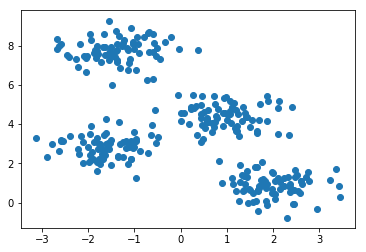

In [177]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

In [62]:
cpm_raw[cpm_raw['cpm']>=5][['account_name','year']].drop_duplicates()

,account_name,year
1066,TV Land,2018
15034,CMT,2018
28843,Logo,2018
37201,VH1,2018
51105,Comedy Central,2018
59994,Nickelodeon,2018
72222,Paramount Network,2018
77421,MTV,2018
91317,BET,2018


In [65]:
cpm_raw.groupby(['account_name','year'])['cpm'].sum()

account_name                       year
16 and Pregnant                    2019        0.000000
@midnight                          2019      104.059224
A Double Shot at Love              2019       21.819036
A Thin Line                        2019      566.017659
Ain't That America With Lil Duval  2019      520.585139
America's Best Dance Crew          2019      689.747625
Another Period                     2019       76.551105
Are You The One?                   2019      614.813689
AwesomenessTV                      2019        0.000000
Awkward                            2019       42.826889
BET                                2018     6252.594418
                                   2019     2778.928177
BET Awards                         2019      767.707192
Basketball Wives                   2019      839.597137
Beavis and Butt-Head               2019      580.038141
Big Time in Hollywood, FL          2019      174.128493
Brickleberry                       2019      169.082861
Broad Ci

In [78]:
mnt18 = cpm_raw[cpm_raw['year']==2018]['month'].drop_duplicates()

In [87]:
cpm_raw[cpm_raw['month'].isin(mnt18)][['account_name','year','cpm']].pivot_table(index = 'account_name', columns = 'year', aggfunc = 'mean' ).dropna()

cpm          
year                   2018      2019
account_name                         
BET                3.256560  0.000000
CMT                3.740069  0.319151
Comedy Central     3.751766  0.312263
Logo               3.756247  0.576402
MTV                3.739997  0.000000
Nickelodeon        3.746993  0.319912
Paramount Network  3.391274  0.317609
TV Land            3.756722  0.323870
VH1                3.745077  0.000000

In [271]:
pg_level[(pg_level['month']==5)&(pg_level['year']==2019)&(pg_level['day']==23)& (pg_level['age']=='18-24')&(pg_level['hID']==125204949641318504)]

,Unnamed: 0,date,name,value,hID,year,month,day,weekday,sex,age,age_min,age_max,female,male,Avg Organic Traffic,Predicted CPM
2291274,1269418,2019-05-23,page_impressions_by_age_gender_unique,2935.0,125204949641318504,2019,5,23,3,M,18-24,18,24,0,1,1119.0,0.810337
2291485,1271479,2019-05-23,page_impressions_by_age_gender_unique,52919.0,125204949641318504,2019,5,23,3,F,18-24,18,24,1,0,1119.0,0.791838
2291729,1273922,2019-05-23,page_impressions_by_age_gender_unique,620.0,125204949641318504,2019,5,23,3,U,18-24,18,24,1,1,1119.0,0.779127


In [277]:
page_level[(page_level['month']==5)&(page_level['year']==2019)&(page_level['day']==23)& (page_level['hID']==125204949641318504)]

,Unnamed: 0,date,name,metric,value,hID,year,month,day,weekday,Genre
28140096,1268572,2019-05-23,page_fans_online,17,88638.0,125204949641318504,2019,5,23,3,NaN
28140097,1268573,2019-05-23,page_impressions_by_city_unique,"Denver, CO",229.0,125204949641318504,2019,5,23,3,NaN
28140101,1268577,2019-05-23,page_impressions_by_city_unique,"Portland, OR",185.0,125204949641318504,2019,5,23,3,NaN
28140102,1268578,2019-05-23,page_impressions_by_locale_unique,tl_PH,9.0,125204949641318504,2019,5,23,3,NaN
28140258,1268734,2019-05-23,page_impressions_by_age_gender_unique,F.45-54,12.0,125204949641318504,2019,5,23,3,NaN
28140265,1268741,2019-05-23,page_impressions_by_locale_unique,cs_CZ,1.0,125204949641318504,2019,5,23,3,NaN
28140307,1268783,2019-05-23,page_impressions_by_country_unique,RU,2.0,125204949641318504,2019,5,23,3,NaN
28140325,1268801,2019-05-23,page_impressions_by_city_unique,"Indianapolis, IN",333.0,125204949641318504,2019,5,23,3,NaN
28140326,1268802,2019-05-23,page_impressions_by_country_unique,CH,1.0,125204949641318504,2019,5,23,3,NaN
28140327,1268803,2019-05-23,page_impressions_by_locale_unique,mr_IN,1.0,125204949641318504,2019,5,23,3,NaN


In [276]:
page_level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33744732 entries, 0 to 33744731
Data columns (total 11 columns):
Unnamed: 0    int64
date          datetime64[ns]
name          object
metric        object
value         float64
hID           int64
year          int64
month         int64
day           int64
weekday       int64
Genre         object
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 3.0+ GB
